# Convolutional Neural Network

- 실행은 주피터 노트북에서 실행하는 것 추천

### Importing the libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
# 케라스 라이브러리 -> 이미지 전처리 모듈 ImageDataGenerator 클래스 불러오기

In [ ]:
tf.__version__

'2.12.0'

## Part 1 - Data Preprocessing / 데이터 전처리

### Preprocessing the Training set / 훈련데이터셋 전처리
- 훈련 데이터셋에 이미지 증강 적용
  - 이미지를 회전, 반전 등 여러 변화를 줌
  - CNN모델이 기존 이미지에서 지나친 학습 방지 -> 과적합 방지

keras 이미지 전처리 API에 관한 설명 ->
https://keras.io/ko/preprocessing/image/

In [ ]:
# 이미지 테이터 생성기 객체 생성
train_datagen = ImageDataGenerator(
        rescale=1./255, # 이미지 픽셀 스케일링(정규화)
        # 이미지 픽셀(0~255)을 255로 나누어 0~1값으로 전환

        shear_range=0.2, # 이미지 기울기 변화
        zoom_range=0.2,  # 이미지 확대 변화
        horizontal_flip=True) # 이미지 수평 반전

**ImageDataGenerator 속성**
- rotation_range : 이미지회전값
- zoom_range : 이미지일부확대
- shear_range : 이미지기울기
- width_shift_range : 좌우이동
- height_shift_range : 상하이동
- horizontal_flip : 이미지가로뒤집기
- vertical_filp : 이미지세로뒤집기

In [ ]:
# 구글드라이브 마운트를 위한 함수 입력
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# flow_from_directory : 이미지 증강 도구를 훈련세트 이미지에 연결
training_set = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/유데미 강의/머신러닝 딥러닝(Codes and DataSets)/Part 8 - Deep Learning/Section 40 - Convolutional Neural Networks (CNN)/Section 40 - Convolutional Neural Networks (CNN)/dataset/training_set',
        # 훈련세트가 있는 경로 입력
        target_size=(64, 64), # 이미지 전달 사이즈 -> 사이즈가 클수록 시간이 오래걸림
        batch_size=32, # 일반적인 배치사이즈
        class_mode='binary') # 이진분류 : binary

Found 0 images belonging to 2 classes.


### Preprocessing the Test set / 테스트 데이터셋 전처리

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
# 스케일링의 경우 훈련세트와 동일하게 처리
# 테스트 데이터의 경우 스케일링 외 원본 유지

In [ ]:
test_set = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/유데미 강의/머신러닝 딥러닝(Codes and DataSets)/Part 8 - Deep Learning/Section 40 - Convolutional Neural Networks (CNN)/Section 40 - Convolutional Neural Networks (CNN)/dataset/test_set',
        target_size=(64, 64), # 훈련세트와 동일한 사이즈
        batch_size=32, # 훈련세트와 동일한 배치
        class_mode='binary')

Found 1958 images belonging to 2 classes.


## Part 2 - Building the CNN / CNN 구축

### Initialising the CNN

In [ ]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution / 컨볼루션 단계

In [ ]:
# convolution layer 생성
cnn.add(tf.keras.layers.Conv2D(filters = 32, # 특징감지기(필터) 갯수
                               kernel_size = 3, # 특징감지기(필터) 사이즈 (3X3행렬)
                               activation = 'relu', # 적용 함수 선택
                               input_shape = [64,64,3])) # 입력 형태 (64X64사이즈 이미지)
                                                        # 컬러의 경우 3, 흑백의 경우 1 입력


### Step 2 - Pooling / 풀링 단계

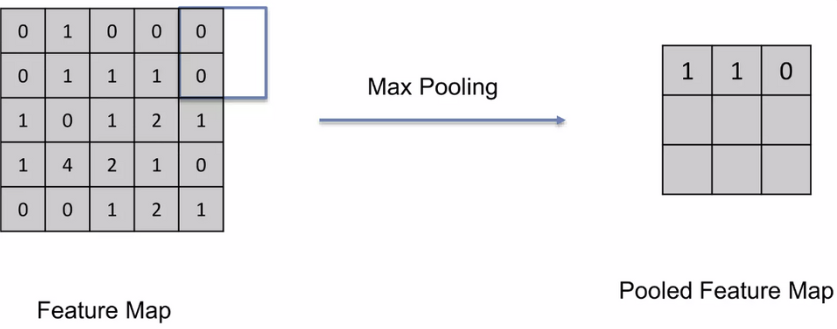

In [ ]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, # 풀링 시 지정 할 행렬 크기 (2X2인경우 2)
                                  strides = 2)) # 풀링 후 옮겨 갈 간격 크기 (행렬크기와 같은 값)
                        # padding : 풀링 중 가장자리가 빈 행렬인 경우 0 으로 설정
                        # -> 기본값 'valid' : 마지막 셀 무시, 0으로 채움 (큰 차이 x)

### Adding a second convolutional layer / 2번째 컨볼루션 추가

In [ ]:
# 첫번째 컨볼루션, 패딩 과정 그대로 삽입
cnn.add(tf.keras.layers.Conv2D(filters = 32,
                               kernel_size = 3,
                               activation = 'relu'))
                               # input_shape = [64,64,3] ->처음 conv층에만 입력
                               # 2번째 층에는 1층에서 설정 된 input_shape가 그대로 옴
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2,
                                  strides = 2))

### Step 3 - Flattening / 1차원 벡터화

In [ ]:
cnn.add(tf.keras.layers.Flatten())

### Step 4 - Full Connection

In [ ]:
# ANN 실습과 마찬가지 -> 벡터화 된 데이터를 분석 할 은닉층 생성
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))

### Step 5 - Output Layer

In [ ]:
# 은닉층과 연결 된 최종 출력층 생성
cnn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
# 이진분류 최종 출력층 : units :1 (0 or 1), activation : sigmoid
# 다중분류의 경우 -> activation : softmax

## Part 3 - Training the CNN / CNN 훈련시키기

### Compiling the CNN / CNN 컴파일

훈련, 평가를 동시에 진행

In [ ]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# 학습방식 :경사하강법 , 손실함수:cross_entropy, 정확도 측정

### Training the CNN on the Training set and evaluating it on the Test set

In [ ]:
cnn.fit(training_set, test_set, epochs = 25)

## Part 4 - Making a single prediction / 단일 이미지 예측 테스트

In [ ]:
import numpy as np
from keras.preprocessing import image
# 예측하고자 하는 이미지 파일을 test_image 변수에 저장
test_image = image.load_img('/content/drive/MyDrive/유데미 강의/머신러닝 딥러닝(Codes and DataSets)/Part 8 - Deep Learning/Section 40 - Convolutional Neural Networks (CNN)/Section 40 - Convolutional Neural Networks (CNN)/dataset/single_prediction/cat_or_dog_1.jpg',
                            target_size = (64,64))
# target_size : 훈련 시 적용한 이미지 사이즈와 동일한 사이즈

# 이미지를 PIL로 변환 = 2D array 로 변환
test_image = image.img_to_array(test_image)



# CNN은 배치32로 32장의 이미지씩 훈련 -> 가중치 업데이트되는 방식
# 단일 이미지도 배치에 포함이 되어야 함.
# CNN 모델이 배치를 추가적인 dimension(차원)으로 인식.
# 배치에 해당하는 추가 dimension을 추가

# 사실 이부분 무슨말인지 잘 모르겠음......
test_image = np.expand_dims(test_image, axis = 0)

# 이미지를 정규화 하여 결과값을 result저장 -> 0 ~ 1 사이 값으로 출력
result = cnn.predict(test_image/255.0) # 정규화를 위해 / 255.0

# 0, 1중 고양이, 개에 해당하는 값을 알려주는 속성
training_set.class_indices
# -> 결과 : 고양이 0 / 개 1


# 출력값에 결과 표시
# 결과는 배치에 포함되어 있음
# ex) 1번째 이미지의 결과는 배치의 1번째 의 1번에 저장 -> [0][0]으로 인덱싱
# test_image 하나만 넣었기 때문에 배치 안의 첫번째이자 유일한 요소에 접근
# 결과(1일 확률)가 0.5 이상이면 dog..
if result[0][0] > 0.5:
  prediction = 'dog'
else:
  prediction = 'cat'

In [ ]:
print(prediction)